In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)
import math
from utils import *
import itertools



In [2]:
# Test with tau=0.9
nS = 8
nA = 2
seed = 3231
status_step = 500
gamma = 0.9
river = River(nS, gamma, 5, 1000)
tau = 0.3
xi = np.ones(river.nS)*1/river.nS
tmdp = TMDP(river, xi, tau, gamma, seed)
tmdp_0 = TMDP(river, xi, 0, gamma, seed)
tmdp_1 = TMDP(river, xi, 0.02, gamma, seed)

colors = itertools.cycle(["r", "b"])

In [3]:
# Optimal Q function
r_s_a = compute_r_s_a(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward)
Q_star = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward, 1e-4, gamma)
J_star = get_expected_avg_reward(tmdp.P_mat, get_policy(Q_star), tmdp.reward, tmdp.gamma, tmdp.mu)
delta_q = np.linalg.norm(Q_star - Q_star, np.inf)

In [4]:
#taus = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
results = []
intermediate_results = {}
curr_j = []
delta_qs = []

Q = np.zeros((tmdp.nS, tmdp.nA))
M = 200000

s = tmdp.reset()
a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])

Q, inner_J, inner_delta_qs = Q_learning(tmdp, s, a, Q, Q_star, M=M, alpha=0.04, debug=True, status_step=status_step)
intermediate_results['tau_'+str(tau)] = {'J': inner_J, "delta_q":inner_delta_qs}
delta_q = np.linalg.norm(Q_star - Q, np.inf)

# Test the policy extracted from Q on the original problem
J = get_expected_avg_reward(tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)

results.append({"type":"scratch", "Q": Q, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q})

In [5]:

Q_1 = np.zeros((tmdp_1.nS, tmdp_1.nA))
M = 200000

s = tmdp_1.reset()
a = eps_greedy(s, Q_1, 1., tmdp_1.allowed_actions[s.item()])

Q_1, inner_J, inner_delta_qs = Q_learning(tmdp_1, s, a, Q_1, Q_star, M=M, alpha=0.04, debug=True, status_step=status_step)
intermediate_results['tau_'+str(tmdp_1.tau)] = {'J': inner_J, "delta_q":inner_delta_qs}
delta_q = np.linalg.norm(Q_star - Q_1, np.inf)

# Test the policy extracted from Q on the original problem
J = get_expected_avg_reward(tmdp_1.P_mat, get_policy(Q_1), tmdp_1.reward, tmdp_1.gamma, tmdp_1.mu)

results.append({"type":"scratch", "Q": Q_1, "tau":"{:.2f}".format(tmdp_1.tau), "J":J, "policy":get_policy(Q_1),"delta_q":delta_q})

In [6]:
Q_0 = Q 
#Q_0 = np.zeros((tmdp_0.nS, tmdp_0.nA))
M = 200000

s = tmdp_0.reset()
a = eps_greedy(s, Q_0, 1., tmdp_0.allowed_actions[s.item()])

Q_0, inner_J, inner_delta_qs = Q_learning(tmdp_0, s, a, Q_0, Q_star, M=M, alpha=0.04, debug=True, status_step=status_step)
intermediate_results['tau_'+str(tmdp_0.tau)] = {'J': inner_J, "delta_q":inner_delta_qs}
delta_q = np.linalg.norm(Q_star - Q_0, np.inf)

# Test the policy extracted from Q on the original problem
J = get_expected_avg_reward(tmdp_0.P_mat, get_policy(Q_0), tmdp_0.reward, tmdp_0.gamma, tmdp_0.mu)

results.append({"type":"scratch", "Q": Q_0, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q_0),"delta_q":delta_q})

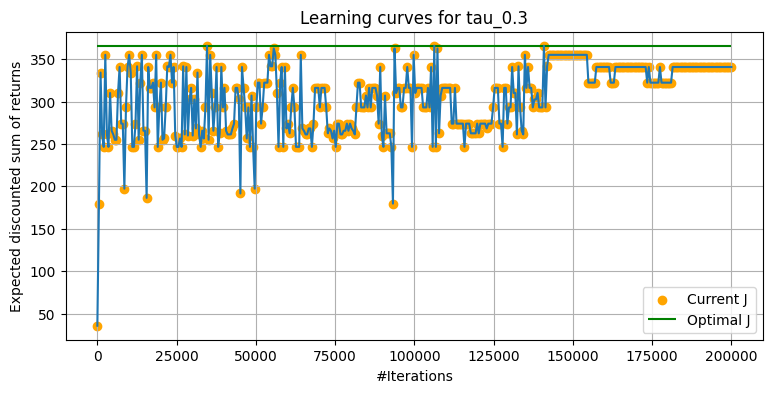

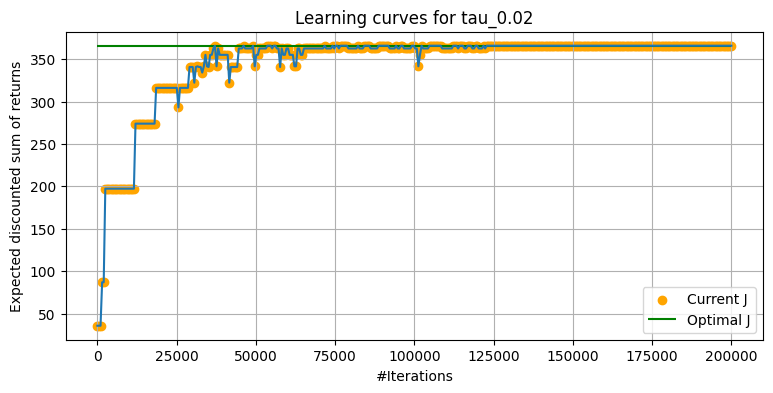

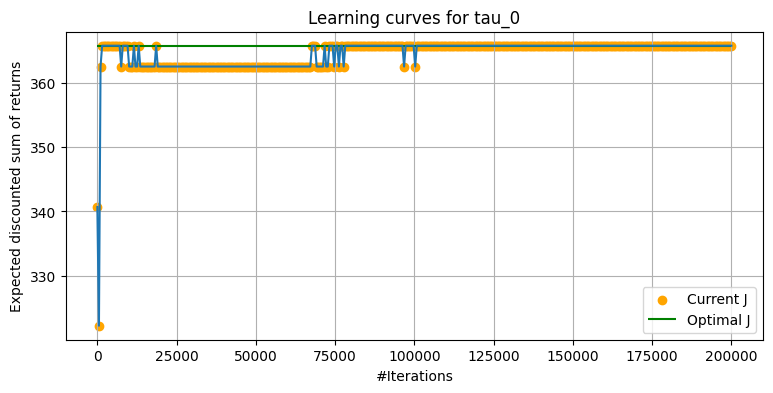

In [7]:
for i, key in enumerate(intermediate_results.keys()):
    xmax = len(intermediate_results[key]['J'])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]['J']))
    y = intermediate_results[key]['J']
    plt.figure(figsize=(9, 4))
    plt.scatter(x, y, c='orange', label='Current J')
    plt.hlines(y=J_star, xmin=0, xmax=xmax, colors=['green'], label='Optimal J')
    plt.plot(x, y)
    plt.grid(visible=True)
    plt.legend(loc="lower right")
    plt.xlabel('#Iterations')
    plt.ylabel('Expected discounted sum of returns')
    plt.title('Learning curves for '+str(key))

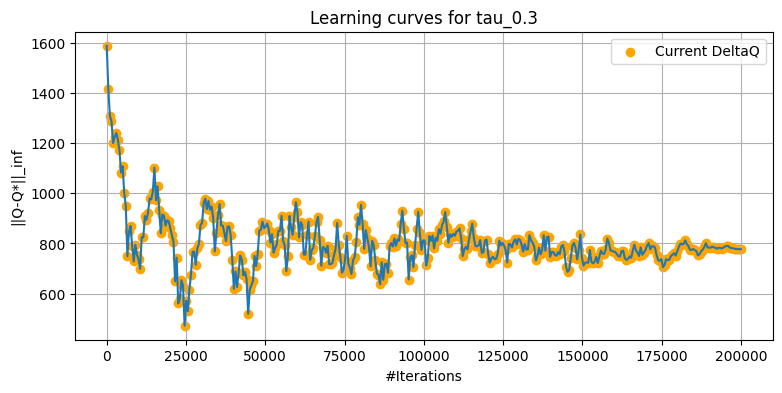

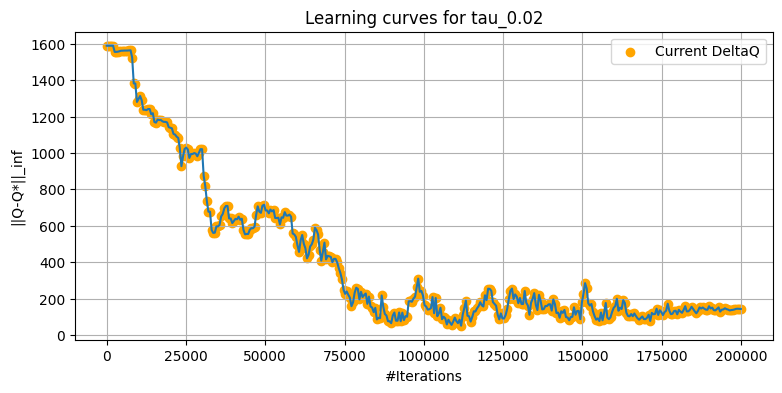

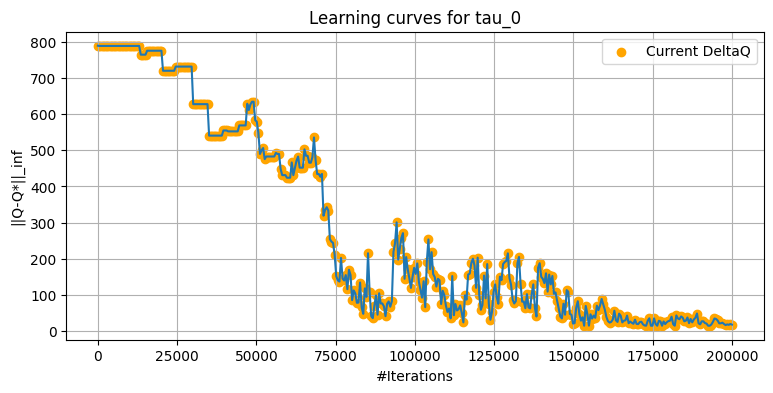

In [8]:
for i, key in enumerate(intermediate_results.keys()):
    xmax = len(intermediate_results[key]['delta_q'])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]['delta_q']))
    y = intermediate_results[key]['delta_q']
    plt.figure(figsize=(9, 4))
    plt.scatter(x, y, c='orange', label='Current DeltaQ')
    plt.plot(x, y)
    plt.legend(loc="upper right")
    plt.xlabel('#Iterations')
    plt.ylabel('||Q-Q*||_inf')
    plt.grid(visible=True)
    plt.title('Learning curves for '+str(key))

In [9]:
# Veryfying the expected value of the difference among the two transition models
z = 2*(abs(tmdp.tau - tmdp_0.tau))
for i in range(tmdp.P_mat_tau.shape[0]):
    x = np.linalg.norm(tmdp.P_mat_tau[i] - tmdp_0.P_mat_tau[i], 1)
    print("Expected difference among the two transition models {}. Theoretical Upperbound {}".format(x, z))

get_expected_difference_transition_models(tmdp.P_mat_tau, tmdp.P_mat)

get_sup_difference_transition_models(tmdp.P_mat_tau, tmdp.P_mat)

Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.44999999999999996. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.39. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.39. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.38999999999999996. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.39. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the

0.525

In [10]:
# Veryfing the L_1 norm of the difference among the gamma discounted state distributions
d_0 = compute_d(tmdp_0.mu, tmdp_0.P_mat_tau, get_policy(Q_star), tmdp_0.gamma)
delta_0 = compute_delta(d_0, get_policy(Q_star))

d = compute_d(tmdp.mu, tmdp.P_mat_tau, get_policy(Q), tmdp.gamma)
delta = compute_delta(d, get_policy(Q))

d_1 = compute_d(tmdp_1.mu, tmdp_1.P_mat_tau, get_policy(Q_1), tmdp_1.gamma)
delta_1 = compute_delta(d_1, get_policy(Q_1))

print(d_0)
print(delta_0)

print(d)
print(delta)

print(d_1)
print(delta_1)

z = 2*(abs(tmdp.tau - tmdp_1.tau))
d_1_d = np.linalg.norm(d_1 - d, 1)
upp_bound_d = tmdp.gamma*z/(1-tmdp.gamma)

print("Expected difference among the two gamma discounted state distributions {}. Theoretical Upperbound {}".format(d_1_d, upp_bound_d))


[0.0522 0.0759 0.0921 0.1044 0.1182 0.152  0.2834 0.1219]
[[0.     0.0522]
 [0.     0.0759]
 [0.     0.0921]
 [0.     0.1044]
 [0.     0.1182]
 [0.     0.152 ]
 [0.     0.2834]
 [0.     0.1219]]
[0.0958 0.1158 0.1221 0.1242 0.1254 0.1312 0.1853 0.1002]
[[0.     0.0958]
 [0.     0.1158]
 [0.     0.1221]
 [0.     0.1242]
 [0.     0.1254]
 [0.     0.1312]
 [0.     0.1853]
 [0.     0.1002]]
[0.0574 0.0819 0.0978 0.1088 0.1205 0.1492 0.2679 0.1165]
[[0.     0.0574]
 [0.     0.0819]
 [0.     0.0978]
 [0.     0.1088]
 [0.     0.1205]
 [0.     0.1492]
 [0.     0.2679]
 [0.     0.1165]]
Expected difference among the two gamma discounted state distributions 0.23374349067160982. Theoretical Upperbound 5.040000000000001


In [11]:
# Difference in performance when moving from tau to tau prime keeping the same policy
print(results[1]['J'] - results[0]['J'])

# Let's see what we can expect from theoretical bounds we have found



25.104193165421123


In [12]:
A_tau_tau_prime = get_discounted_distribution_relative_model_advantage_function(tmdp.P_mat_tau, tmdp_1.P_mat_tau, tmdp.reward, tmdp.gamma, Q, tmdp.mu)
print(A_tau_tau_prime)
D = get_difference_transition_models(tmdp.P_mat_tau, tmdp_1.P_mat_tau, tmdp.gamma)
print(D)
print(4*tmdp.gamma*(tmdp.tau-tmdp_1.tau)**2)

D_Q = get_sup_difference_q(Q)
print(D_Q)

print(tmdp.gamma* D_Q*D/(2*(1-gamma)**2))
print(compute_performance_improvement_lower_bound(A_tau_tau_prime, tmdp.gamma, D_Q, D))

-5.116050764987178
0.191394
0.28223999999999994
914.6637011261282
7877.751498600042
-7928.912006249914


## 1-step transfer learning test. From tau to original problem

In [13]:
taus = [0.9, 0.7, 0.6, 0.4, 0.2, 0.09, 0.07, 0.05, 0.04, 0.02, 0.01]
results = []
intermediate_results = {}
curr_j = []
delta_qs = []
status_step = 500

# Learning from scratch with different values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    Q = np.zeros((tmdp.nS, tmdp.nA))
    M = 200000
    
    s = tmdp.reset()
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    
    Q, inner_J, inner_delta_qs = Q_learning(tmdp, s, a, Q, Q_star, M=M, alpha=0.03, debug=True, status_step=status_step, main_p=False)
    
    intermediate_results['tau_'+str(tau)] = {'J': inner_J, "delta_q":inner_delta_qs, 'Q':Q, "tmdp":tmdp}
    delta_q = np.linalg.norm(Q_star - Q, np.inf)
    
    J = get_expected_avg_reward(tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
    results.append({"type":"scratch", "Q": Q, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q, "tmdp":tmdp})

    s = tmdp_0.reset()
    a = eps_greedy(s, Q, 1., tmdp_0.allowed_actions[s.item()])
    Q, inner_J, inner_delta_qs = Q_learning(tmdp_0, s, a, Q, Q_star, M=M, alpha=0.03, debug=True, status_step=status_step)
    intermediate_results['transfer_'+str(tau)] = {'J': inner_J, "delta_q":inner_delta_qs, 'Q':Q, "tmdp":tmdp_0}
    delta_q = np.linalg.norm(Q_star - Q, np.inf)

    J = get_expected_avg_reward(tmdp_0.P_mat, get_policy(Q), tmdp_0.reward, tmdp_0.gamma, tmdp_0.mu)
    results.append({"type":"transfer", "Q": Q, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q, "tmdp":tmdp_0})

In [14]:
agg_res = aggregate_results(results, len(results))

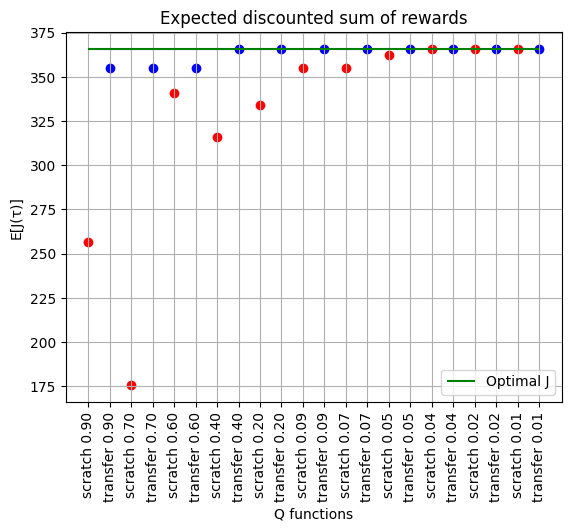

In [24]:
x = np.array([])
y = np.array([])
ci = np.array([])
for res in agg_res:
    yi =res['avg_J']
    y = np.append(y, yi)
    label = res['type'] + " " + str(res['tau'])
    x = np.append(x, label)
    ci = np.append(ci, res['ci_J'])
    plt.scatter(label, yi, c=next(colors))
x_map = np.array([i for i in range(len(x))])
offset = np.array([0.25 if ci[i] > 0.001 else 0 for i in range(len(x))])
#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

plt.xticks(x_map, x)
#plt.plot(x, y)
#plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.hlines(y=y-ci, xmin=x_map-offset, xmax=x_map + offset)
plt.hlines(y=y+ci, xmin=x_map-offset, xmax=x_map + offset)
plt.hlines(y=J_star, xmin=0, xmax=len(x)-1, colors=['green'], label='Optimal J')
plt.vlines(x, ymin = y-ci, ymax = y+ci)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards")
plt.grid(visible=True)
plt.legend(loc="lower right")

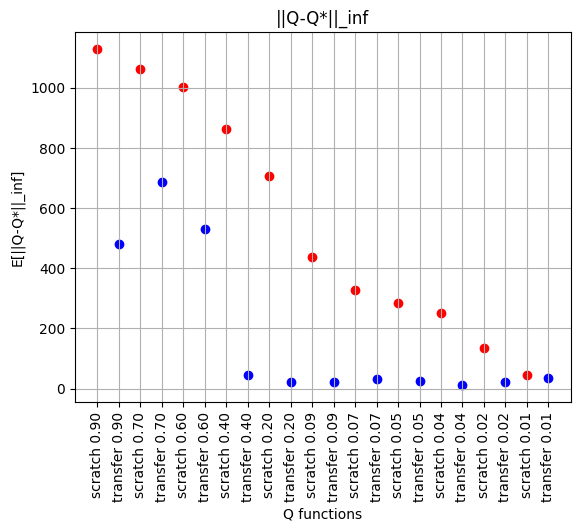

In [16]:
x = np.array([])
y = np.array([])
ci = np.array([])
for res in agg_res:
    yi = res['avg_delta_q']
    y = np.append(y, yi)
    label = res['type'] + " " + str(res['tau']) 
    x = np.append(x, label)
    ci = np.append(ci, res['ci_delta_q'])
    plt.scatter(label, yi, c=next(colors))
offset = np.array([0.25 if ci[i] > 0.001 else 0 for i in range(len(x))])
#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
#plt.scatter(x, y, c='orange')

plt.xticks(x_map, x)
#plt.plot(x, y)
#plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.hlines(y=y-ci, xmin=x_map-offset, xmax=x_map + offset)
plt.hlines(y=y+ci, xmin=x_map-offset, xmax=x_map + offset)
plt.vlines(x, ymin = y-ci, ymax = y+ci)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel('E[||Q-Q*||_inf]')
plt.title("||Q-Q*||_inf")
plt.grid(visible=True)

C:\Users\crist\AppData\Local\Temp\ipykernel_6508\3348398573.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9, 4))


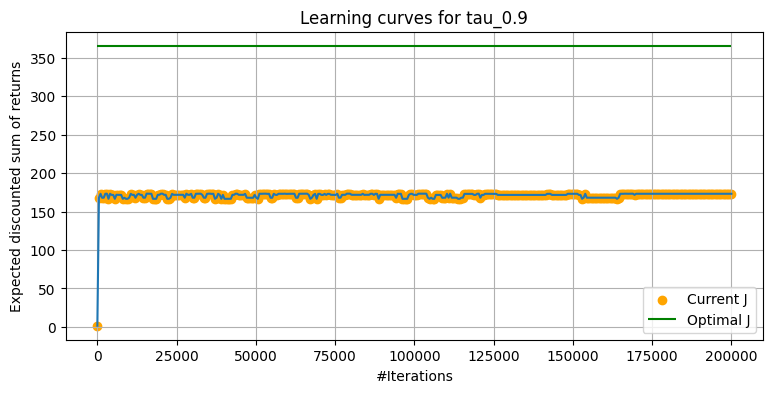

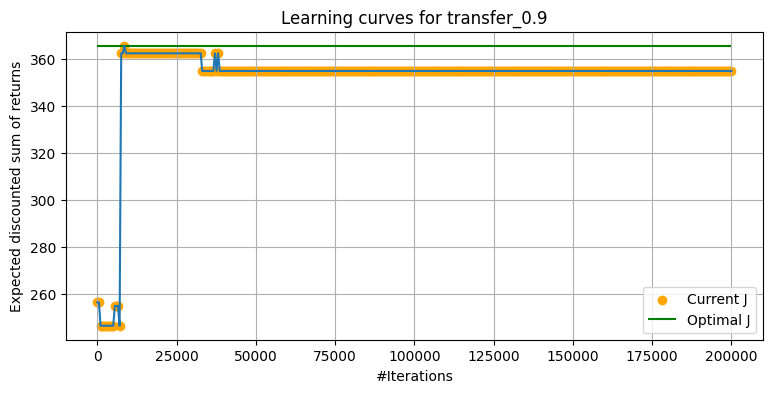

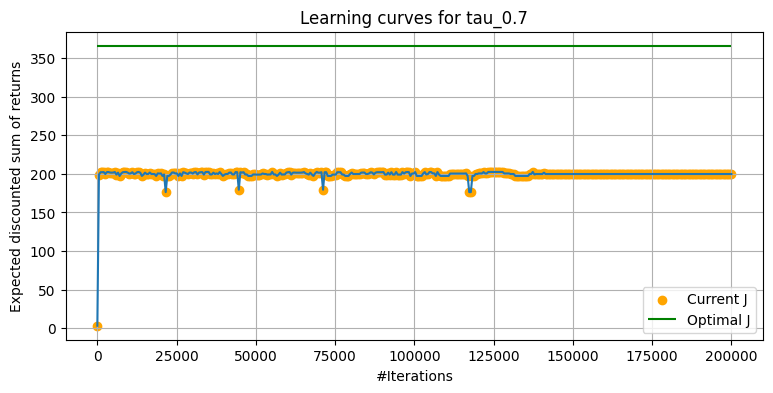

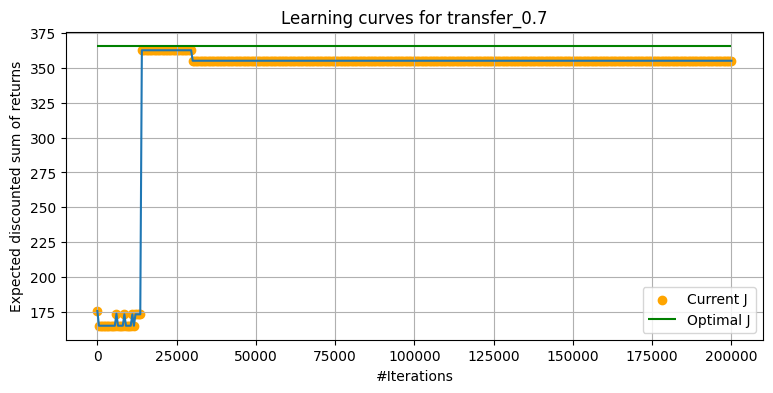

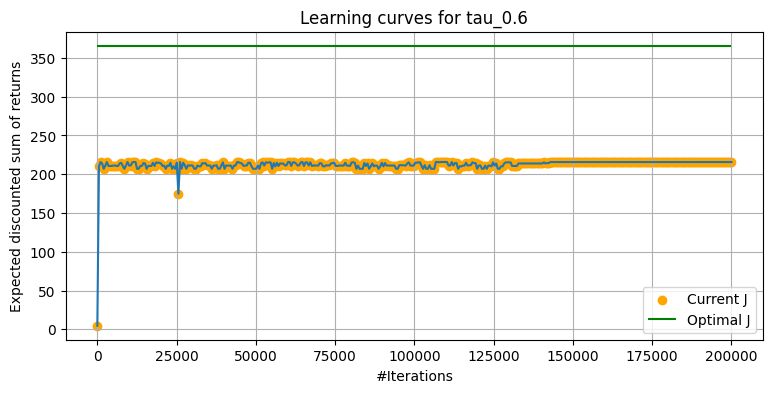

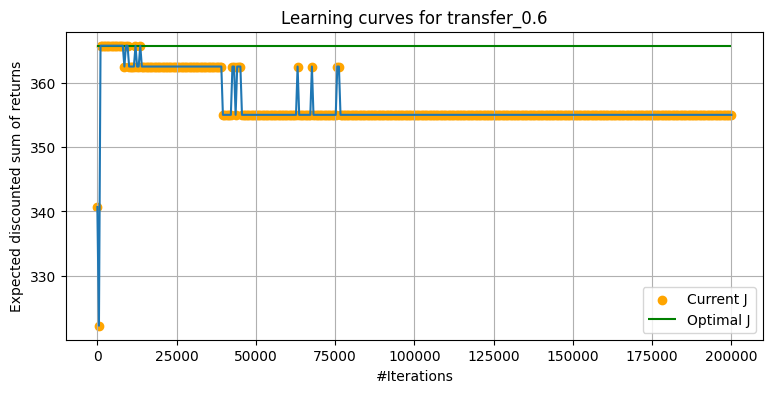

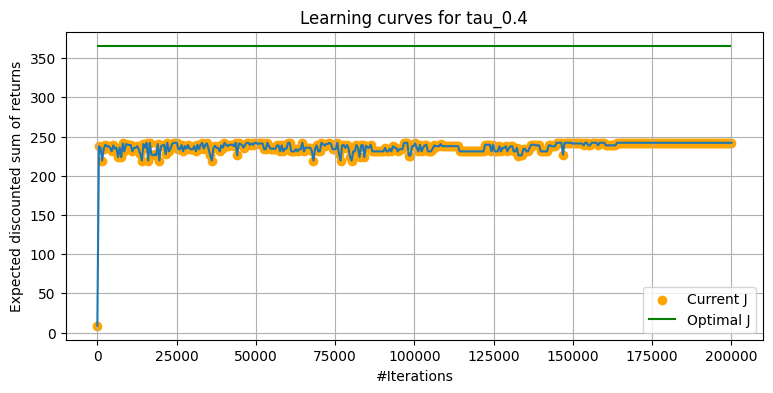

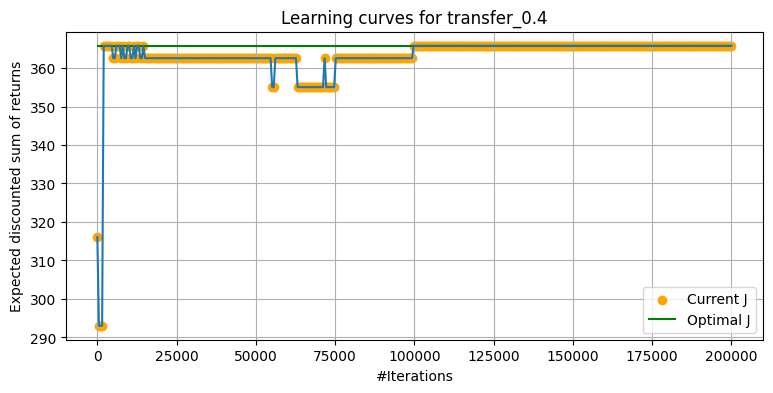

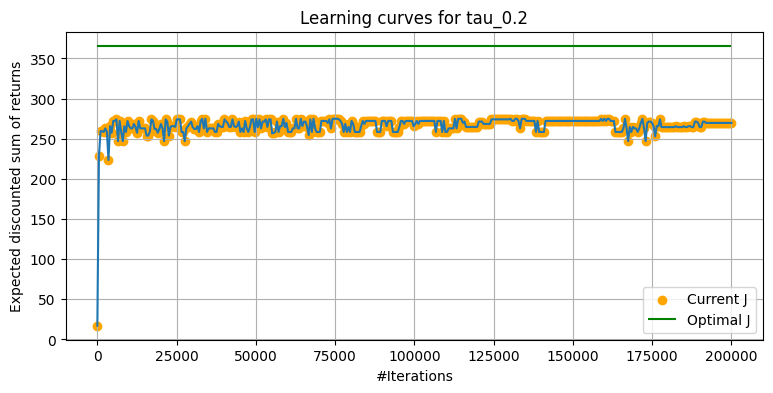

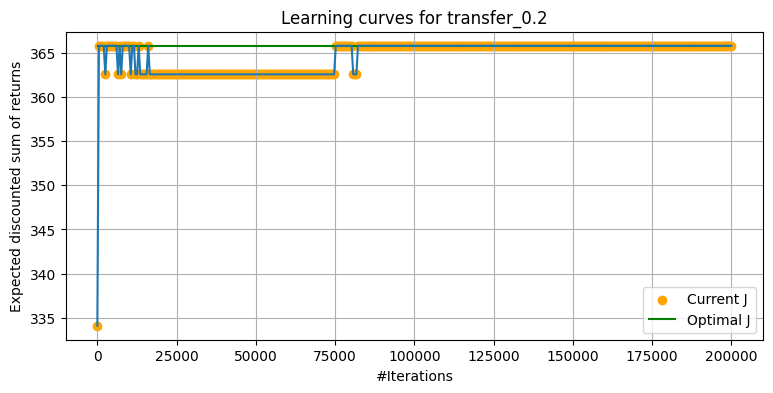

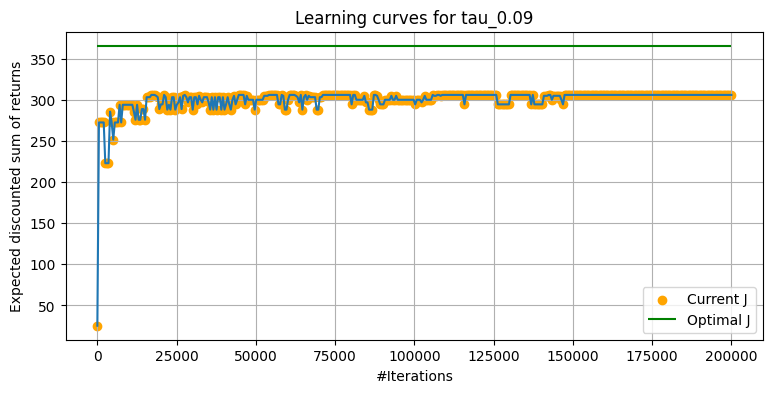

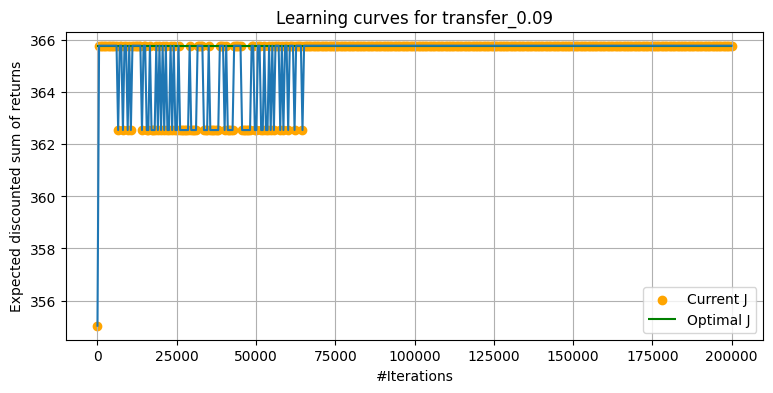

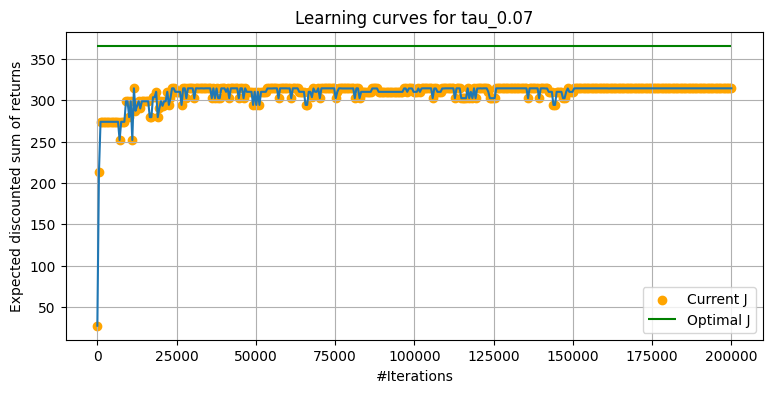

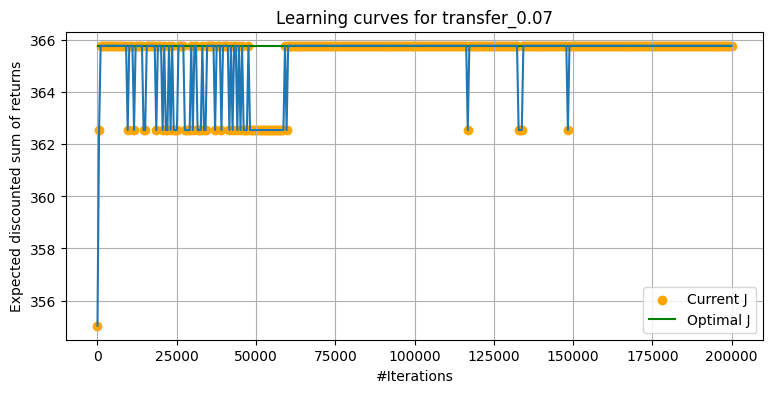

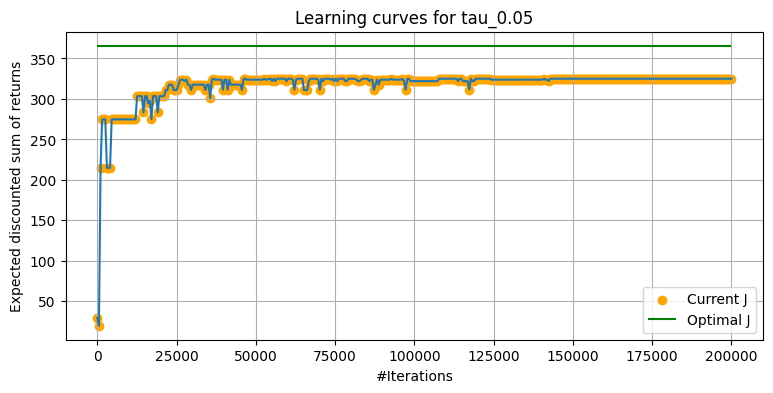

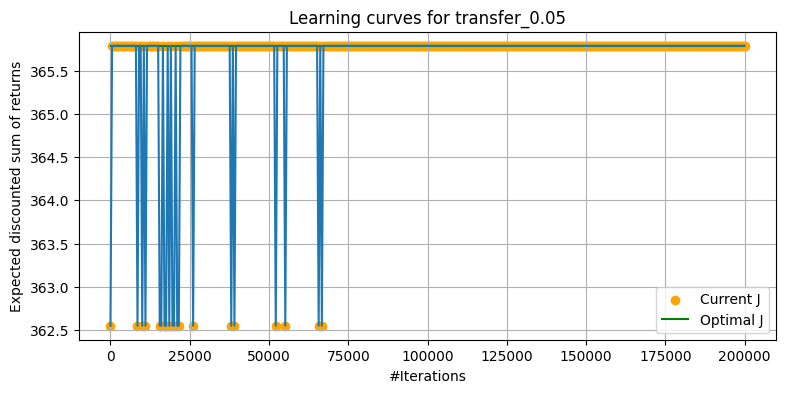

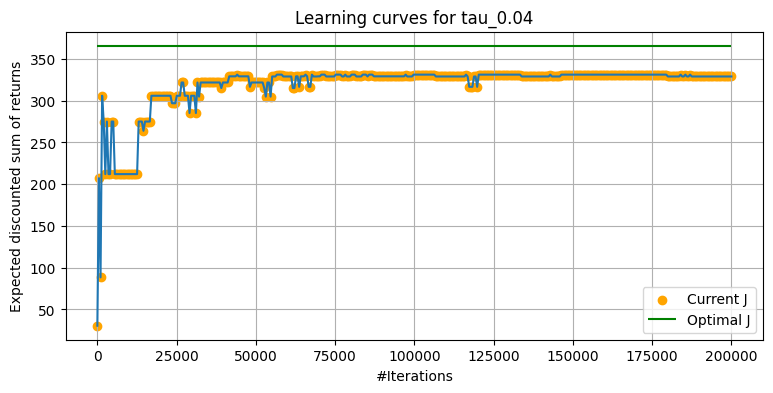

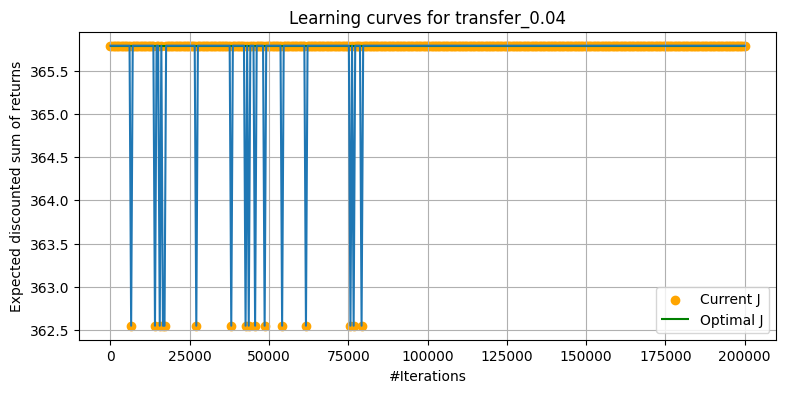

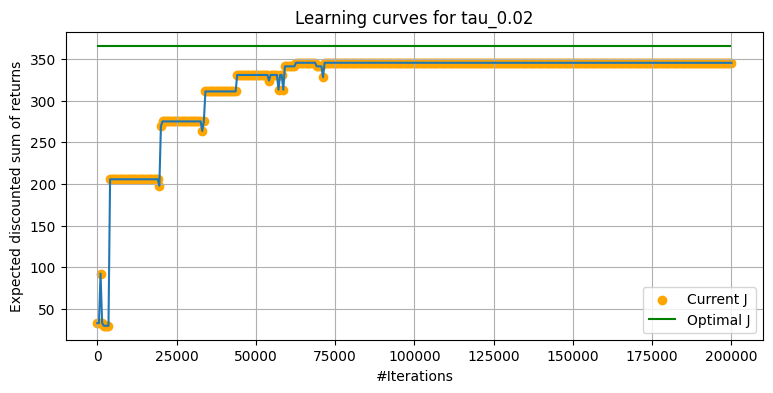

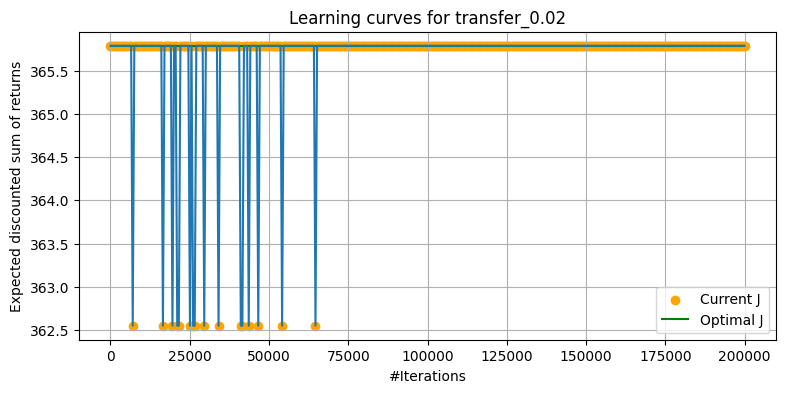

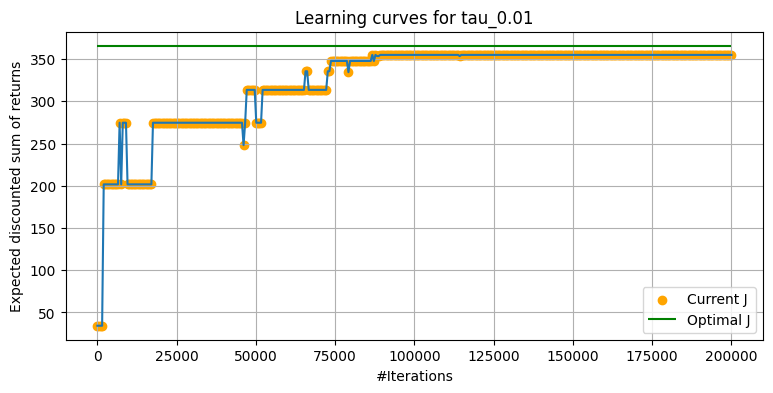

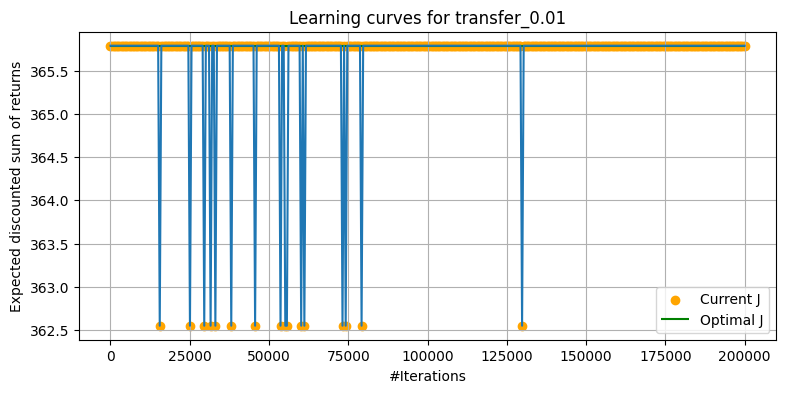

In [17]:
for i, key in enumerate(intermediate_results.keys()):
    xmax = len(intermediate_results[key]['J'])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]['J']))
    y = intermediate_results[key]['J']
    plt.figure(figsize=(9, 4))
    plt.scatter(x, y, c='orange', label='Current J')
    plt.hlines(y=J_star, xmin=0, xmax=xmax, colors=['green'], label='Optimal J')
    plt.plot(x, y)
    plt.grid(visible=True)
    plt.legend(loc="lower right")
    plt.xlabel('#Iterations')
    plt.ylabel('Expected discounted sum of returns')
    plt.title('Learning curves for '+str(key))

C:\Users\crist\AppData\Local\Temp\ipykernel_6508\3885327038.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9, 4))


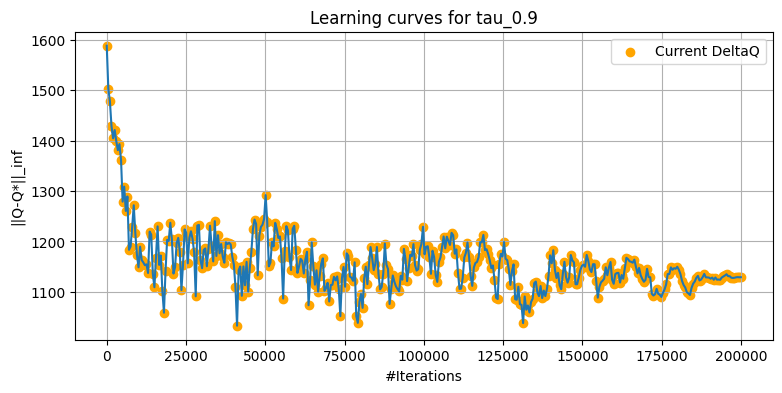

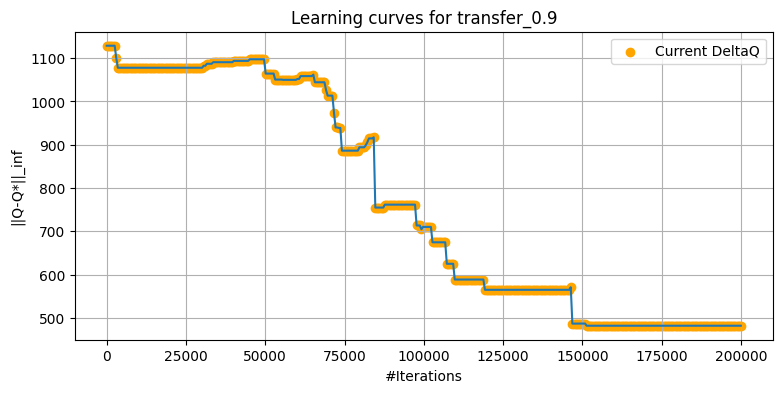

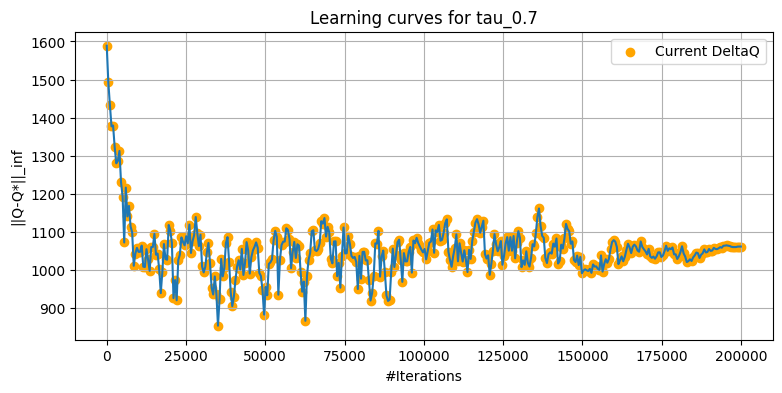

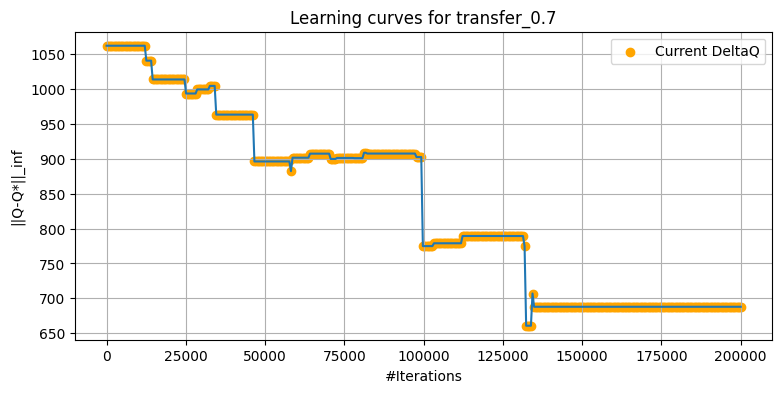

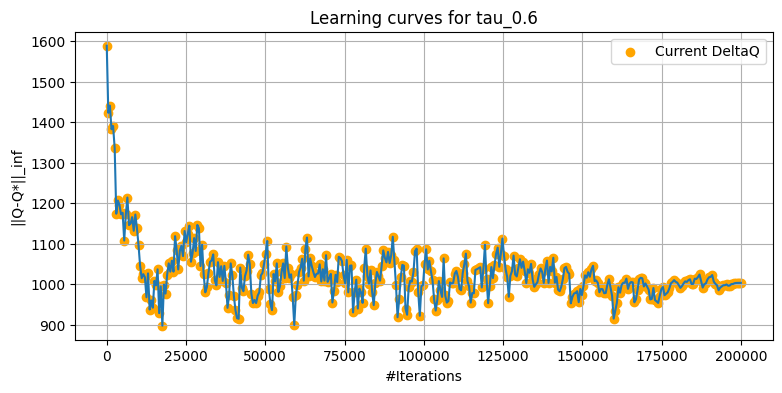

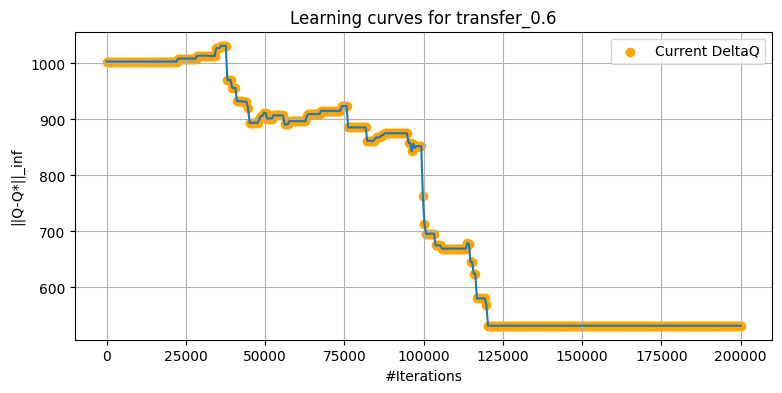

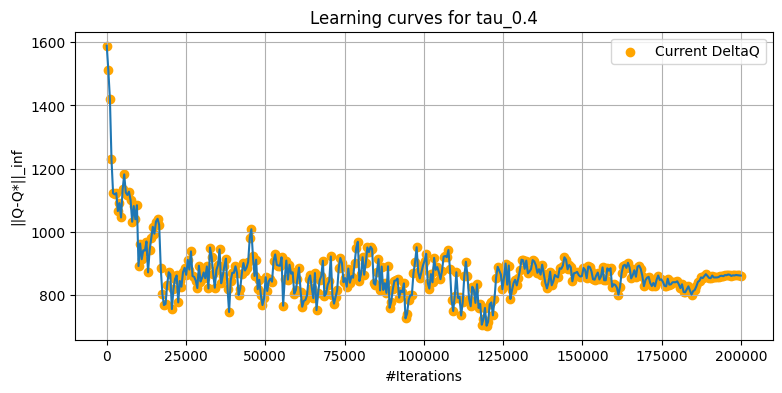

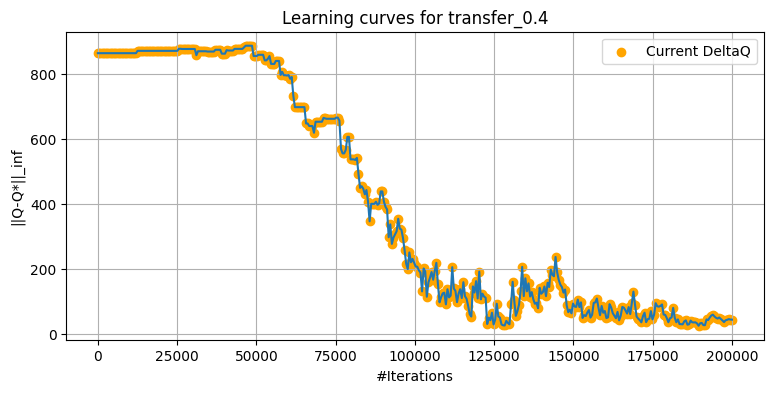

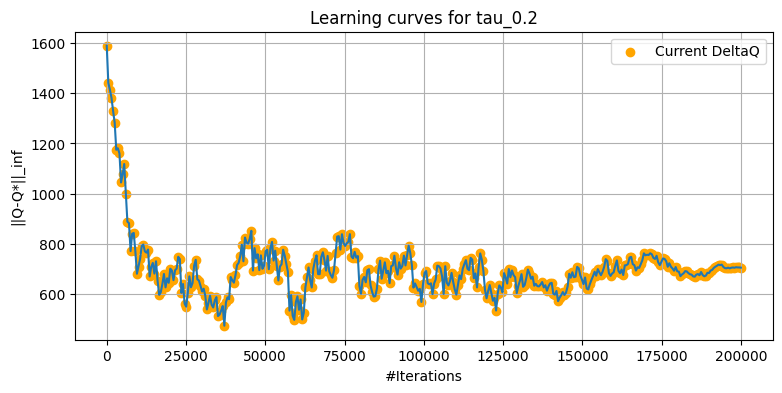

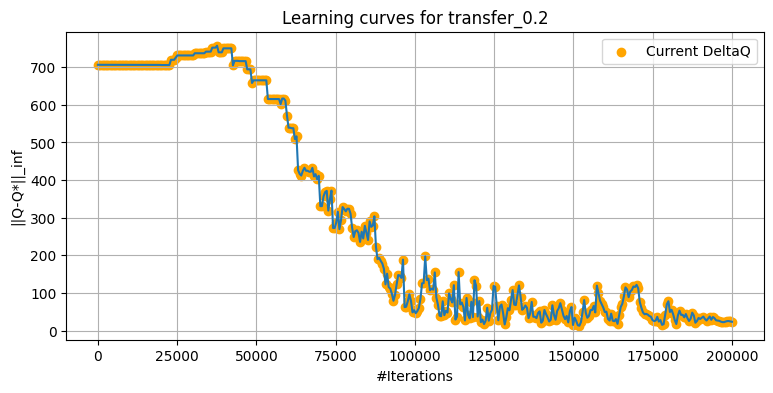

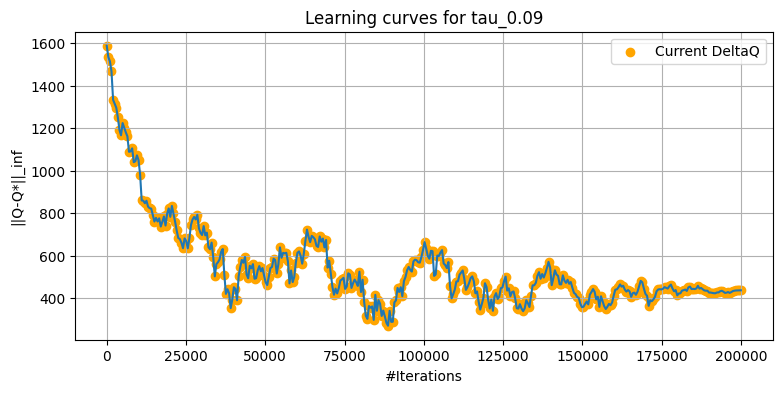

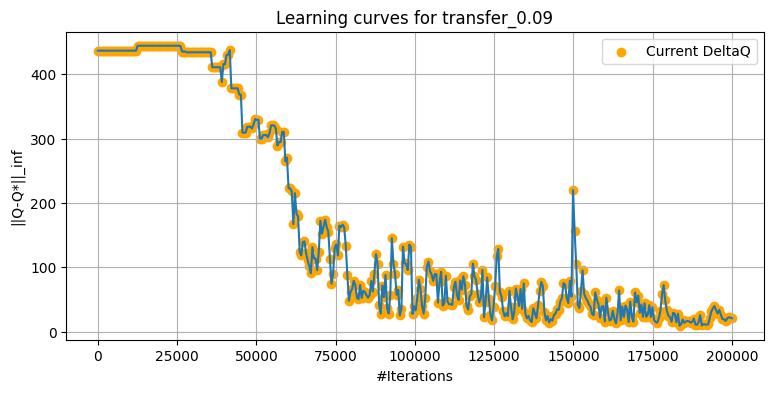

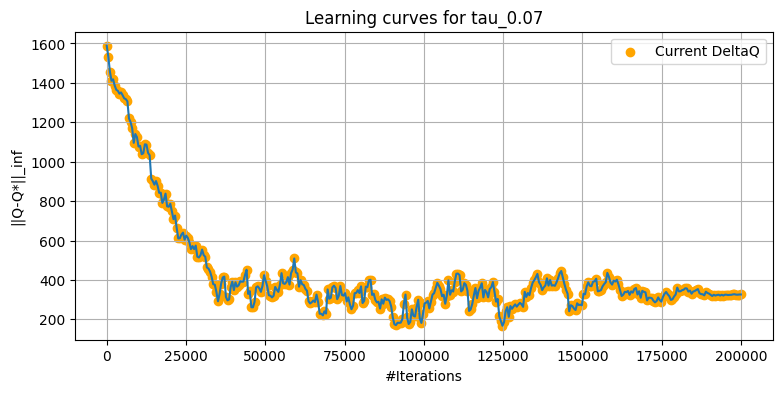

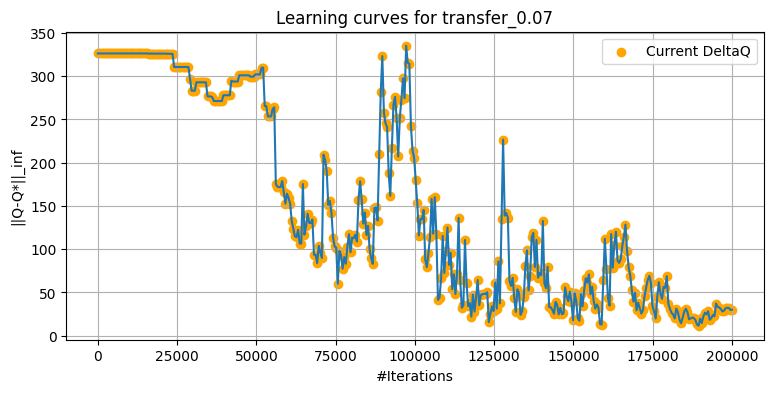

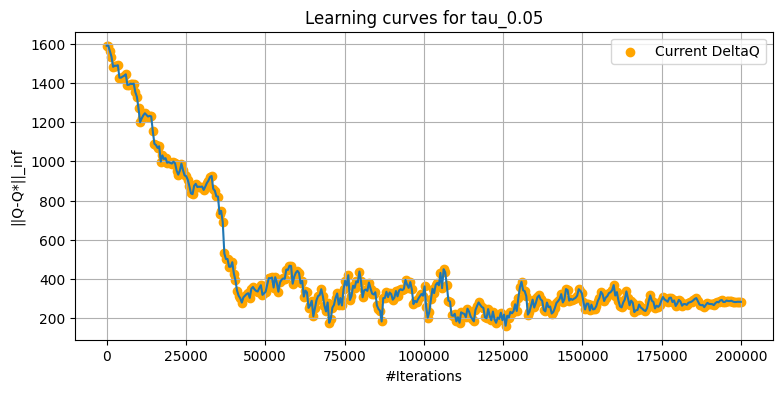

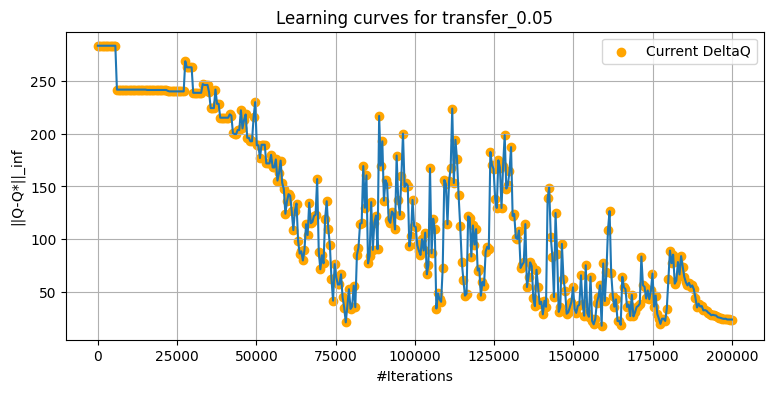

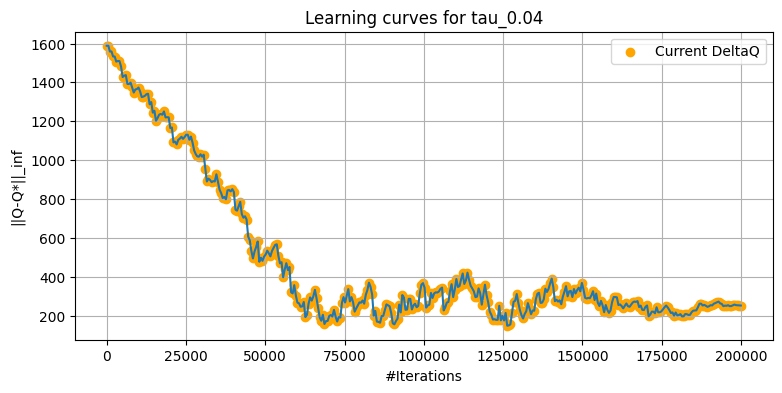

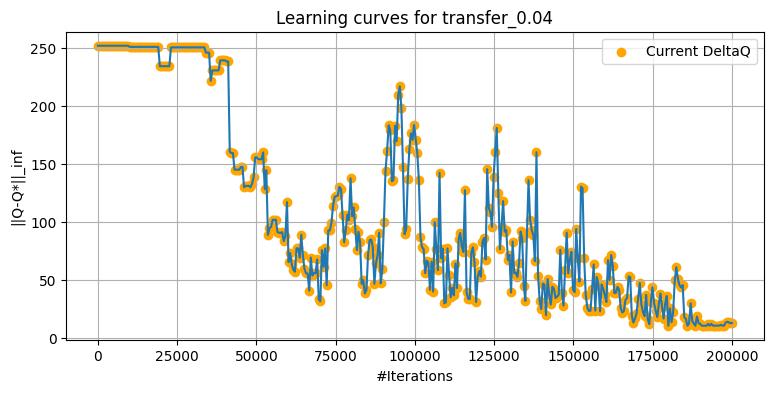

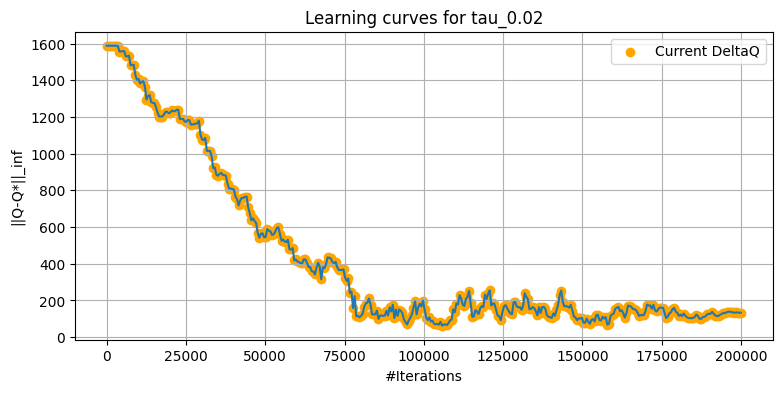

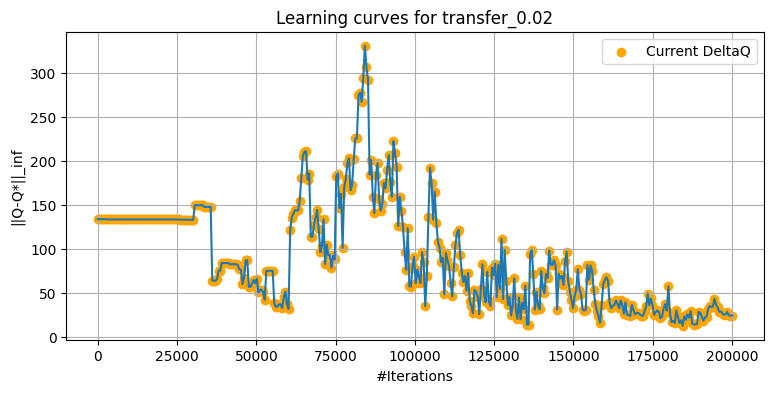

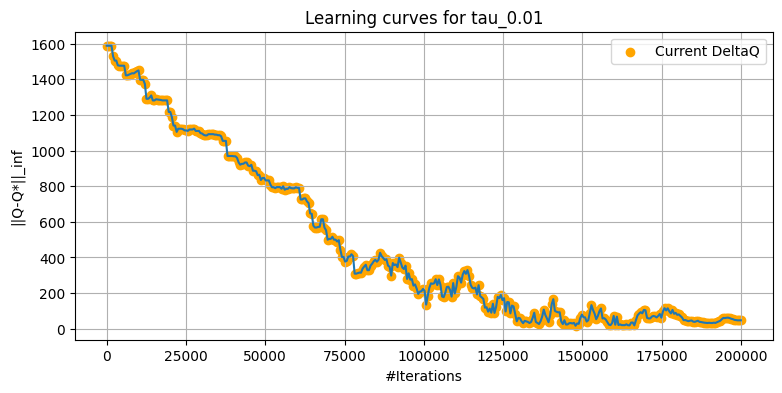

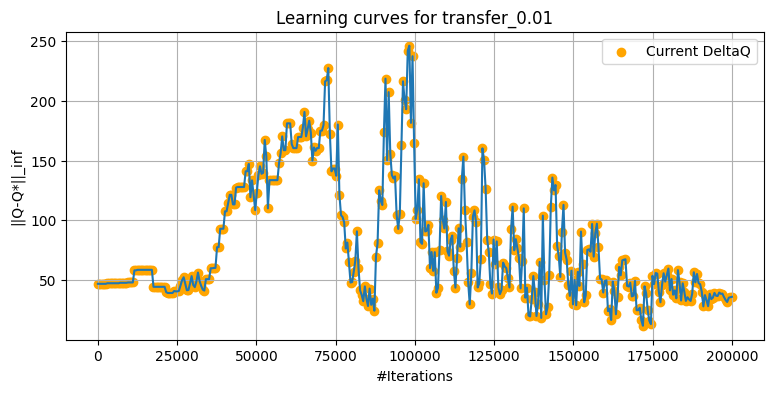

In [18]:
for i, key in enumerate(intermediate_results.keys()):
    xmax = len(intermediate_results[key]['delta_q'])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]['delta_q']))
    y = intermediate_results[key]['delta_q']
    plt.figure(figsize=(9, 4))
    plt.scatter(x, y, c='orange', label='Current DeltaQ')
    plt.plot(x, y)
    plt.legend(loc="upper right")
    plt.xlabel('#Iterations')
    plt.ylabel('||Q-Q*||_inf')
    plt.grid(visible=True)
    plt.title('Learning curves for '+str(key))

In [19]:
print(intermediate_results)

{'tau_0.9': {'J': [1.4594780156954479, 167.93367067931587, 173.14301131105765, 167.9326228872467, 168.04063492893366, 173.11259213260556, 173.26437773473467, 166.59172661870514, 173.12308442631831, 171.6636920861556, 171.66369208615558, 166.59172661870514, 171.8049861668015, 171.80498616680143, 171.6636920861556, 171.6636920861556, 166.59172661870514, 167.93261201746492, 166.59172661870508, 166.59172661870514, 168.0406357432001, 173.11260113943896, 171.66369208615552, 171.80510126778665, 167.9326220048924, 171.8049861668015, 173.14702286046847, 171.80106635102692, 171.6636920861556, 168.04053129603633, 168.05119693340401, 173.26437773473467, 173.26437773473467, 173.26361549393656, 173.14311138256232, 166.59172661870514, 166.59172661870508, 166.59172661870514, 171.80106635102692, 171.8010663510269, 173.25388613141013, 173.24997465350407, 171.80106635102683, 171.8010663510269, 166.59172661870514, 166.59172661870514, 167.93261202656868, 173.00457738978295, 171.8010663510269, 171.801066351

In [20]:
for tau in taus:
    J_tau = intermediate_results['tau_'+str(tau)]['J'][-1]
    J_0_tran = intermediate_results['transfer_'+str(tau)]['J'][0]
    J_0 = intermediate_results['transfer_'+str(tau)]['J'][-1]
    tmdp = intermediate_results['tau_'+str(tau)]['tmdp']
    tmdp_0 = intermediate_results['transfer_'+str(tau)]['tmdp']
    Q = intermediate_results['tau_'+str(tau)]['Q']

    print("J_tau - J_0_trans = {} - {} = {}".format(J_tau, J_0_tran, J_tau - J_0_tran))
    print("Final J after learning for {} iteration from transfer learning = {}".format(M, J_0))
    
    A_tau_tau_prime = get_discounted_distribution_relative_model_advantage_function(tmdp.P_mat_tau, tmdp_0.P_mat_tau, tmdp.reward, tmdp.gamma, Q, tmdp.mu)
    D = get_difference_transition_models(tmdp.P_mat_tau, tmdp_0.P_mat_tau, tmdp.gamma)
    D_Q = get_sup_difference_q(Q)

    #print(tmdp.gamma* D_Q*D/(2*(1-gamma)**2))
    l_bound_J = compute_performance_improvement_lower_bound(A_tau_tau_prime, tmdp.gamma, D_Q, D)
    print("The lower bound for performance improvement when moving from {} to {} is {}\n\n".format(tmdp.tau, tmdp_0.tau, l_bound_J))

J_tau - J_0_trans = 173.14196261874895 - 256.4055696009609 = -83.26360698221197
Final J after learning for 200000 iteration from transfer learning = 355.03300635211065
The lower bound for performance improvement when moving from 0.9 to 0 is -71669.06771206977


J_tau - J_0_trans = 199.70389680199688 - 175.7408278812265 = 23.963068920770382
Final J after learning for 200000 iteration from transfer learning = 355.03300635211065
The lower bound for performance improvement when moving from 0.7 to 0 is -34276.20657376918


J_tau - J_0_trans = 215.74242648472585 - 340.6844168677573 = -124.94199038303145
Final J after learning for 200000 iteration from transfer learning = 355.03300635211065
The lower bound for performance improvement when moving from 0.6 to 0 is -29745.376655002987


J_tau - J_0_trans = 241.99124123927342 - 316.06060621667064 = -74.06936497739721
Final J after learning for 200000 iteration from transfer learning = 365.78861003317843
The lower bound for performance improvement